In [1]:
import re
import os
import pymupdf
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf # For formula-based GLM

mpl.rcParams['figure.dpi'] = 200

Download data from Springer

In [2]:
os.makedirs('data', exist_ok=True)
os.makedirs('assets', exist_ok=True)
os.makedirs('assets/original', exist_ok=True)
os.makedirs('assets/reproduced', exist_ok=True)

if not os.path.exists('data/proposal_data.xlsx'):
    xlsx_link = 'https://static-content.springer.com/esm/art%3A10.1038%2Fnature18315/MediaObjects/41586_2016_BFnature18315_MOESM378_ESM.xlsx'
    urllib.request.urlretrieve(xlsx_link, 'data/proposal_data.xlsx')

xls = pd.ExcelFile('data/proposal_data.xlsx')

In [3]:
# concat all sheets into one dataframe
fundings = pd.concat([pd.read_excel(xls, sheet_name=sheet) for sheet in xls.sheet_names])
fundings.head()


/home/dell/miniconda3/envs/dev-diffuser/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/dell/miniconda3/envs/dev-diffuser/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/dell/miniconda3/envs/dev-diffuser/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/dell/miniconda3/envs/dev-diffuser/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/dell/miniconda3/envs/dev-diffuser/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Startyr,Funding status,Schemecd,Discipline,Primary FOR Cd,Primary FOR %,Primary 4-digit FOR name,FOR code list,Keywords1
0,2011,recommendedForFunding,D-P,PCE,205,50,OPTICAL PHYSICS,"020504(50%), 100506(30%), 090604(20%)",
1,2011,notRecommendedForFunding,D-P,PCE,301,50,ANALYTICAL CHEMISTRY,"030108(50%), 030599(20%), 030601(20%), 039903(...",
2,2011,notRecommendedForFunding,D-P,BSB,601,60,BIOCHEMISTRY AND CELL BIOLOGY,"060199(60%), 039901(40%)",
3,2011,notRecommendedForFunding,D-P,BSB,602,100,ECOLOGY,"060207(80%), 060204(20%)",
4,2011,notRecommendedForFunding,D-P,PCE,202,70,"ATOMIC, MOLECULAR, NUCLEAR, PARTICLE AND PLASM...","020201(70%), 030702(20%), 020110(10%)",


The covariance between two research fields (FOR codes) in the phylogenetic variance-covariance matrix (C) is proportional to the shared branch length from the root of the hierarchy tree to their most recent common ancestor (MRCA).

Details on how to define branch length is missing in the paper, therefore we simplified the calculation as below.

![PSE](./assets/PSE_formula.png)


Self-defined heights for hierarchy levels based on shared prefix length.

Example:
        '010101' and '010102' have shared prefix length 5, so they are at the same height.
        '010101' and '010201' have shared prefix length 4, so they are at different heights.
        '010101' and '020101' have shared prefix length 1, so the height of their common ancestor is 0.

- Shared prefix length 0, 1 -> height 0 (Root level)
- Shared prefix length 2, 3 -> height 1 (Layer 1 ancestor)
- Shared prefix length 4, 5 -> height 2 (Layer 2 ancestor)
- Shared prefix length 6 -> height 3 (Layer 3 - the tip)


In [ ]:
def parse_for_code_list(code_list_str):
    """
    Parses the 'FOR code list' string to extract FOR codes and percentages.
    Returns a list of tuples: [(code, percentage), ...]
    Handles cases with '(...)' by ignoring them for this simplified example.
    """
    if pd.isna(code_list_str):
        return []

    # Use regex to find patterns like 'CODE(PERCENT%)'
    matches = re.findall(r'(\d+)\((\d+)%\)', code_list_str)

    parsed_codes = []
    for match in matches:
        code = match[0]
        percentage = int(match[1])
        parsed_codes.append((code, percentage))

    return parsed_codes

def get_shared_prefix_length(code1, code2):
    """
    Calculates the length of the longest shared prefix between two FOR codes.
    """
    min_len = min(len(code1), len(code2))
    shared_len = 0
    for i in range(min_len):
        if code1[i] == code2[i]:
            shared_len += 1
        else:
            break
    return shared_len

def build_phylogenetic_covariance_matrix_refined_simplified(for_codes):
    """
    REFINED SIMPLIFIED CONCEPTUAL FUNCTION: Builds a simplified variance-covariance matrix (C)
    based on shared prefix lengths and user-defined heights.

    Args:
        for_codes (list): A list of unique FOR code strings in the proposal.

    Returns:
        numpy.ndarray: A simplified variance-covariance matrix (C).
    """
    n = len(for_codes)
    C = np.zeros((n, n))

    height_map = {
        0: 0,
        1: 0,
        2: 1,  # Shared prefix length 2 -> height 1
        3: 1,  # Shared prefix length 3 -> height 1
        4: 2,  # Shared prefix length 4 -> height 2
        5: 2,  # Shared prefix length 5 -> height 2
        6: 3   # Shared prefix length 6 -> height 3
    }

    total_height_6_digit = 3 

    for i in range(n):
        for j in range(n):
            code1 = for_codes[i]
            code2 = for_codes[j]

            if code1 == code2:
                C[i, j] = total_height_6_digit
            else:
                shared_len = get_shared_prefix_length(code1, code2)
                shared_height = height_map.get(shared_len, 0)
                C[i, j] = shared_height

    return C

def calculate_pse(parsed_codes):
    """
    Calculates a simplified Phylogenetic Species Evenness (PSE) for a proposal
    using the refined simplified C matrix calculation based on prefix distance
    and specific height weightings.
    Adapted from the formula in the provided supplementary information.

    Args:
        parsed_codes (list): List of tuples [(code, percentage), ...].

    Returns:
        float: The calculated Simplified PSE score (Illustrative IDD).
               Returns 0.0 for single-disciplinary proposals or if calculation fails.
               Returns np.nan if the denominator is zero.
    """
    if not parsed_codes:
        return 0.0 # Handle cases with no parsed codes

    codes = [code for code, percentage in parsed_codes]
    percentages = np.array([percentage for code, percentage in parsed_codes])

    if len(codes) == 1 and percentages[0] == 100:
        return 0.0

    m = percentages.sum()
    M = percentages.reshape(-1, 1)

    mean_m = percentages.mean()

    try:
        C = build_phylogenetic_covariance_matrix_refined_simplified(codes)
    except Exception as e:
        print(f"Error building refined simplified covariance matrix for codes {codes}: {e}")
        return 0.0 # Or np.nan

    if C.shape[0] != len(codes) or C.shape[1] != len(codes):
        print(f"Covariance matrix size mismatch for codes {codes}. Expected {len(codes)}x{len(codes)}, got {C.shape}")
        raise ValueError()

    # PSE = (m * diag[C]' * M - M' * C * M) / (m^2 - mean_m * m)


    # diag[C]' * M
    diag_C = np.diag(C).reshape(1, -1) # Row vector of diagonal elements

    if diag_C.size == 0 or M.size == 0 or diag_C.shape[1] != M.shape[0]:
        print(f"Matrix shape mismatch for diag_C @ M. diag_C shape: {diag_C.shape}, M shape: {M.shape}")
        raise ValueError()

    term1_numerator = m * (diag_C @ M)[0, 0] # Result is a scalar

    # M' * C * M
    M_transpose = M.transpose()

    if M_transpose.size == 0 or C.size == 0 or M.size == 0 or M_transpose.shape[1] != C.shape[0] or C.shape[1] != M.shape[0]:
        print(f"Matrix shape mismatch for M' @ C @ M. M_transpose shape: {M_transpose.shape}, C shape: {C.shape}, M shape: {M.shape}")
        return np.nan

    term2_numerator = (M_transpose @ C @ M)[0, 0] # Result is a scalar

    numerator = term1_numerator - term2_numerator

    denominator = (m**2 - mean_m * m)

    if denominator == 0:
        return np.nan

    pse_score = numerator / denominator

    return pse_score


df = fundings
df['Parsed_FOR_Codes'] = df['FOR code list'].apply(parse_for_code_list)

df['Simplified_PSE'] = df['Parsed_FOR_Codes'].apply(calculate_pse)

print("DataFrame with Calculated Simplified PSE:")
print(df[['FOR code list', 'Parsed_FOR_Codes', 'Simplified_PSE']].head())


DataFrame with Calculated Simplified PSE:
                                       FOR code list  \
0              020504(50%), 100506(30%), 090604(20%)   
1  030108(50%), 030599(20%), 030601(20%), 039903(...   
2                           060199(60%), 039901(40%)   
3                           060207(80%), 060204(20%)   
4              020201(70%), 030702(20%), 020110(10%)   

                                    Parsed_FOR_Codes  Simplified_PSE  
0         [(020504, 50), (100506, 30), (090604, 20)]            2.79  
1  [(030108, 50), (030599, 20), (030601, 20), (03...            1.76  
2                       [(060199, 60), (039901, 40)]            2.88  
3                       [(060207, 80), (060204, 20)]            0.64  
4         [(020201, 70), (030702, 20), (020110, 10)]            1.86  


In [5]:
df['Primary FOR Cd'].apply(lambda x: str(x).zfill(4)[:2]).unique()

array(['02', '03', '06', '16', '09', '20', '07', '04', '17', '13', '11',
       '01', '19', '15', '21', '22', '08', '05', '18', '10', '12', '14'],
      dtype=object)

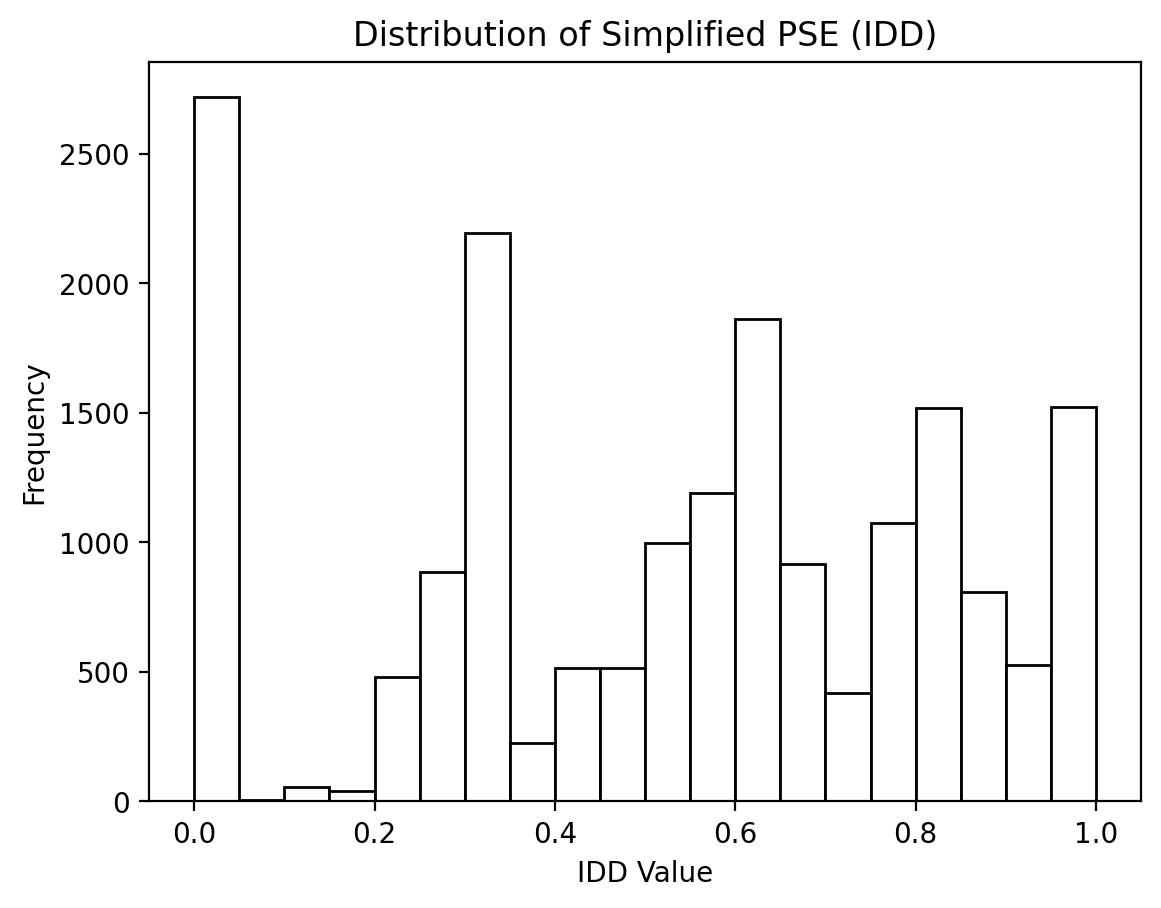

In [6]:
df['IDD'] = df['Simplified_PSE'] / df['Simplified_PSE'].max()
IDD = df['IDD']

plt.hist(IDD, bins=20, edgecolor='black', color='white')
plt.title('Distribution of Simplified PSE (IDD)')
plt.xlabel('IDD Value')
plt.ylabel('Frequency')
plt.show()


There are 1238 defined 6-digit FOR codes, but since applications only need to select one FOR code, and most proposals have 3 or fewer codes (Extended Data Table 1), most columns are zero for any given proposal.

To calculate the null distribution, we will need to get all the codes from supplementary pdf.

In [7]:
len(set([code[0] for code in df['Parsed_FOR_Codes'].values for code in code]))

1176

In [8]:
if not os.path.exists('data/FORCODES.pdf'):
    pdf_link = 'https://static-content.springer.com/esm/art%3A10.1038%2Fnature18315/MediaObjects/41586_2016_BFnature18315_MOESM377_ESM.pdf'
    urllib.request.urlretrieve(pdf_link, 'data/FORCODES.pdf')


In [9]:
doc = pymupdf.open('data/FORCODES.pdf')
text = '\n'.join([page.get_text() for page in doc]).split('\n')

forcodes = {m.group(0) for m in (re.match(r'\d{6}', line) for line in text) if m}

all_possible_for_codes = list(forcodes)
all_possible_for_codes.sort()
len(all_possible_for_codes)

1238

<!-- ![Example Subject Tree](./assets/subject_tree.png =) -->
## Example Subject Tree

We have collectd all codes there

<div>
    <img src="./assets/subject_tree.png" alt="Example Subject Tree" style="width:500px;"/>

</div>


In [10]:
def generate_null_distribution(
    original_proposal_parsed_codes: list[tuple[str, int]],
    all_for_codes_universe: list[str]
) -> float | None:
    """
    Generate a single PSE score for a null hypothesis proposal,
    following the paper's method of randomly sampling FOR codes.

    Args:
        original_proposal_parsed_codes: A list of (FOR_code_string, percentage_int) tuples
                                        for an original proposal.
        all_for_codes_universe: A list of all possible 6-digit FOR codes.

    Returns:
        A single PSE score for the null proposal, or None if it cannot be generated.
    """
    
    num_codes_in_original = len(original_proposal_parsed_codes)

    # The paper states IDD=0 for single-disciplinary.
    if num_codes_in_original <= 1:
        return 0.0
    
    # Extract the original percentages
    original_percentages = [p for _, p in original_proposal_parsed_codes]

    # Randomly select `num_codes_in_original` unique FOR codes
    if len(all_for_codes_universe) < num_codes_in_original:
        print(f"Warning: Not enough unique FOR codes in the universe ({len(all_for_codes_universe)}) "
              f"to sample {num_codes_in_original} for a proposal. Skipping this permutation.")
        return None

    try:
        random_for_codes_sampled = np.random.choice(
            all_for_codes_universe,
            size=num_codes_in_original,
            replace=False
        ).tolist()
    except ValueError as e:
        print(f"Error sampling random codes: {e}. Original codes info: {original_proposal_parsed_codes}")
        return None


    # Pair the randomly sampled codes with the original percentages.
    # The paper implies maintaining the relative weighting, so we preserve the original order of percentages.
    null_proposal_codes_with_percentages = list(
        zip(random_for_codes_sampled, original_percentages)
    )
    
    pse_score = calculate_pse(null_proposal_codes_with_percentages)
    
    return pse_score

proposals_to_sample = df['Parsed_FOR_Codes'].dropna()

sample_size = len(proposals_to_sample)
sample_proposals = proposals_to_sample.sample(n=sample_size, random_state=42).tolist()

null_scores = []
for original_proposal in sample_proposals:
    pse_score = generate_null_distribution(
        original_proposal, 
        all_possible_for_codes
    )
    if pse_score is not None:
        null_scores.append(pse_score)

null_scores = np.array(null_scores)

print(f"Generated {len(null_scores)} null PSE scores.")

Generated 18476 null PSE scores.


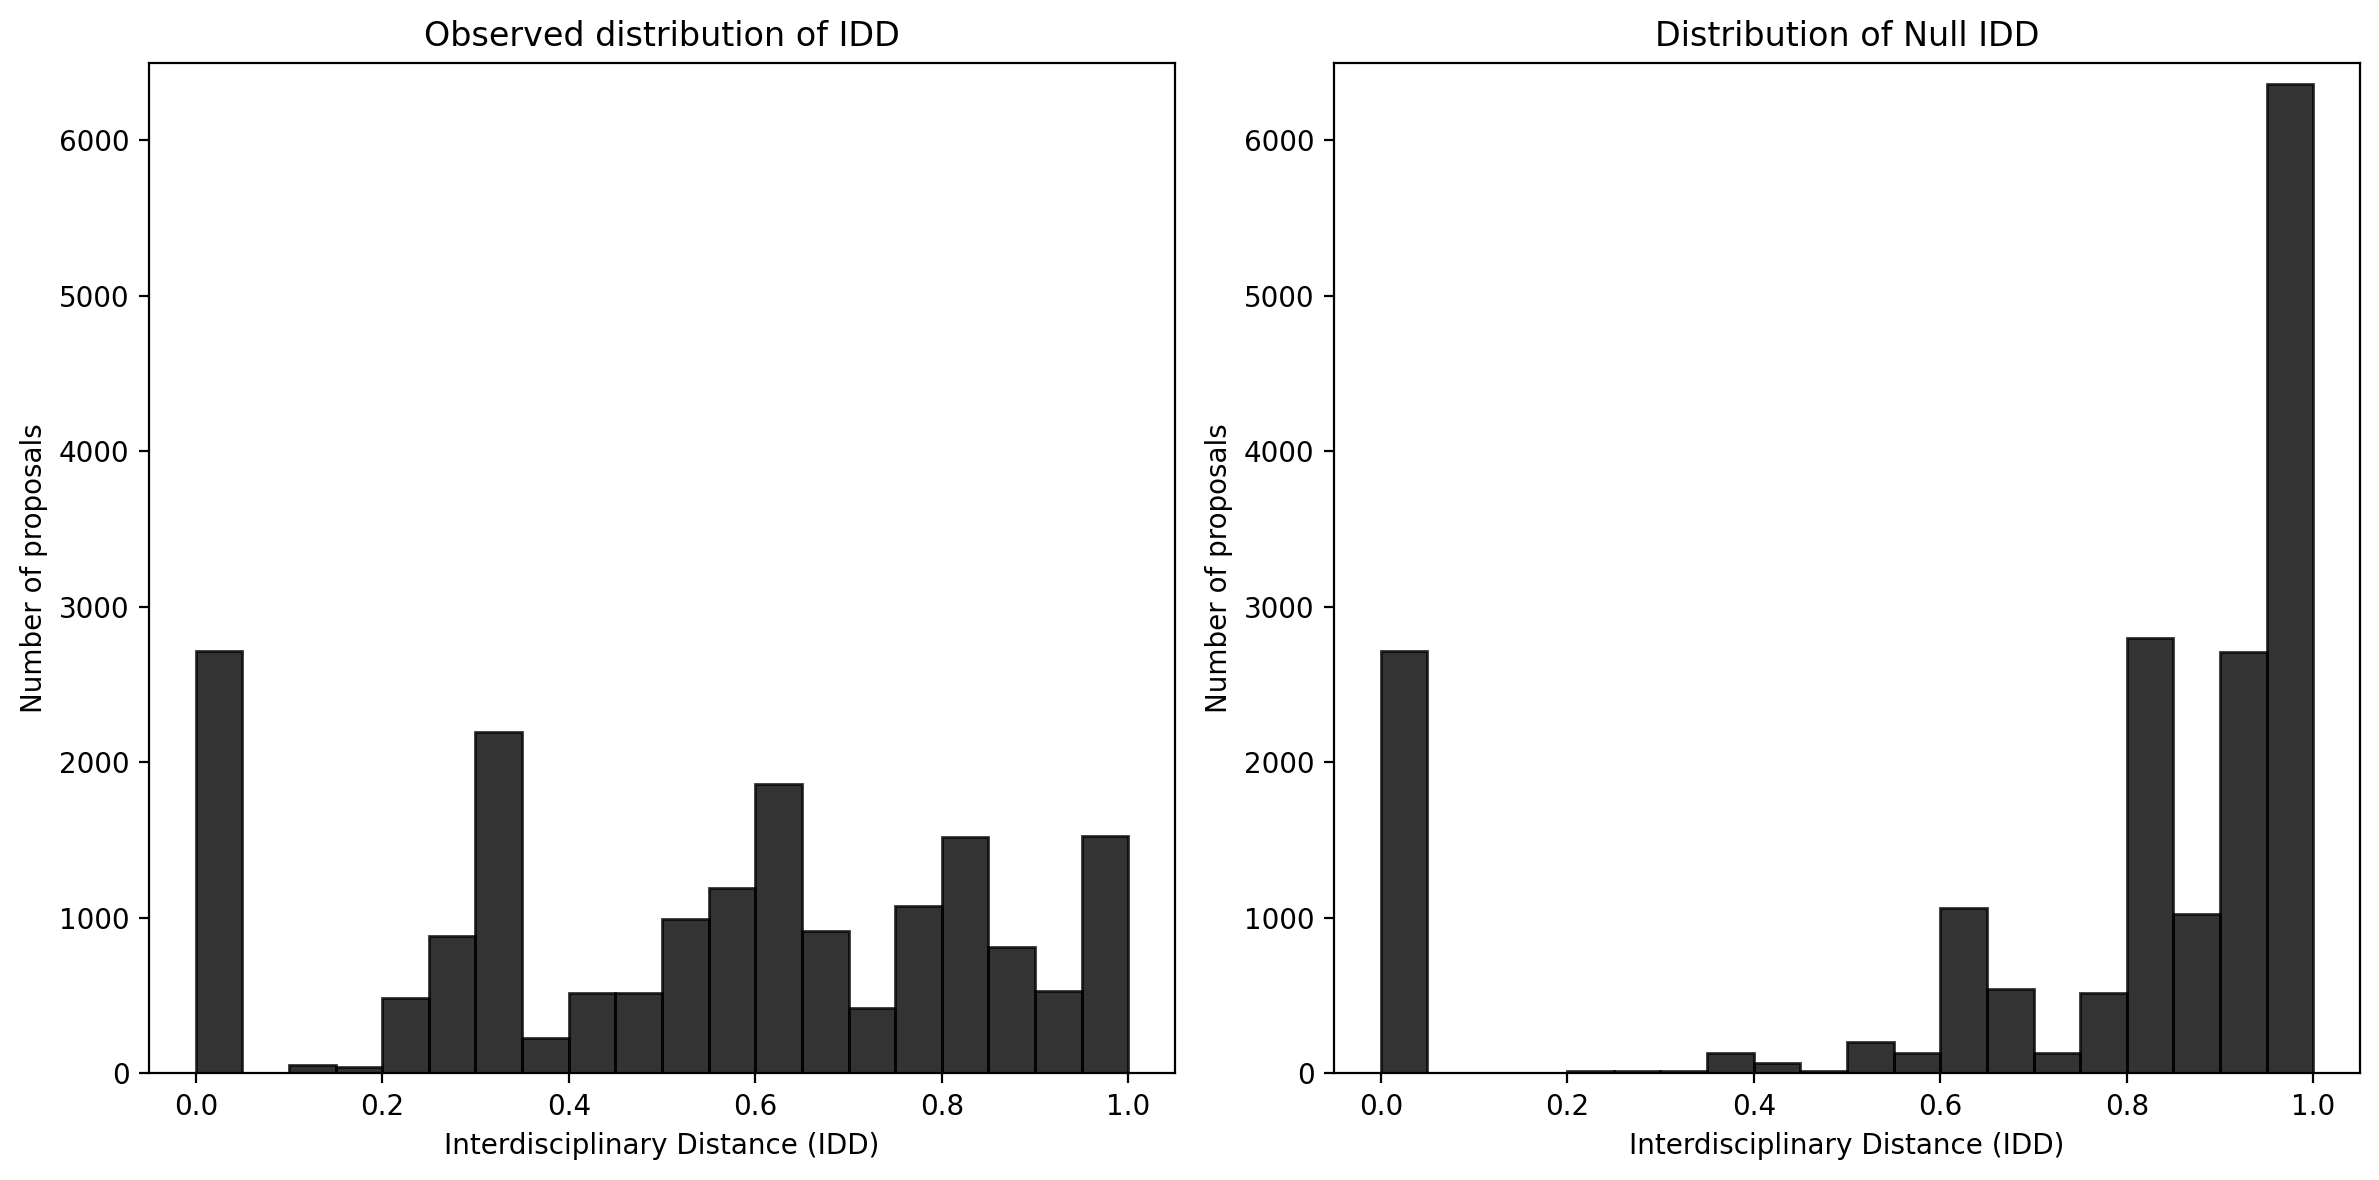

In [11]:
plt.figure(figsize=(12, 6))

# Plot observed distribution
plt.subplot(1, 2, 1)
observed_scores = df['Simplified_PSE'].dropna()
observed_scores = observed_scores / observed_scores.max()  # Normalize
plt.hist(observed_scores, bins=20, edgecolor='black', color='black', alpha=0.8)
plt.title('Observed distribution of IDD')
plt.ylim(0, 6500)
plt.xlabel('Interdisciplinary Distance (IDD)')
plt.ylabel('Number of proposals')


# Plot null distribution
plt.subplot(1, 2, 2)
null_scores = null_scores / null_scores.max()  # Normalize
plt.hist(null_scores, bins=20, edgecolor='black', color='black', alpha=0.8)
plt.title('Distribution of Null IDD')
plt.ylim(0, 6500)
plt.xlabel('Interdisciplinary Distance (IDD)')
plt.ylabel('Number of proposals')

plt.tight_layout()
plt.show()


### Styling

Maybe style more like that in the paper

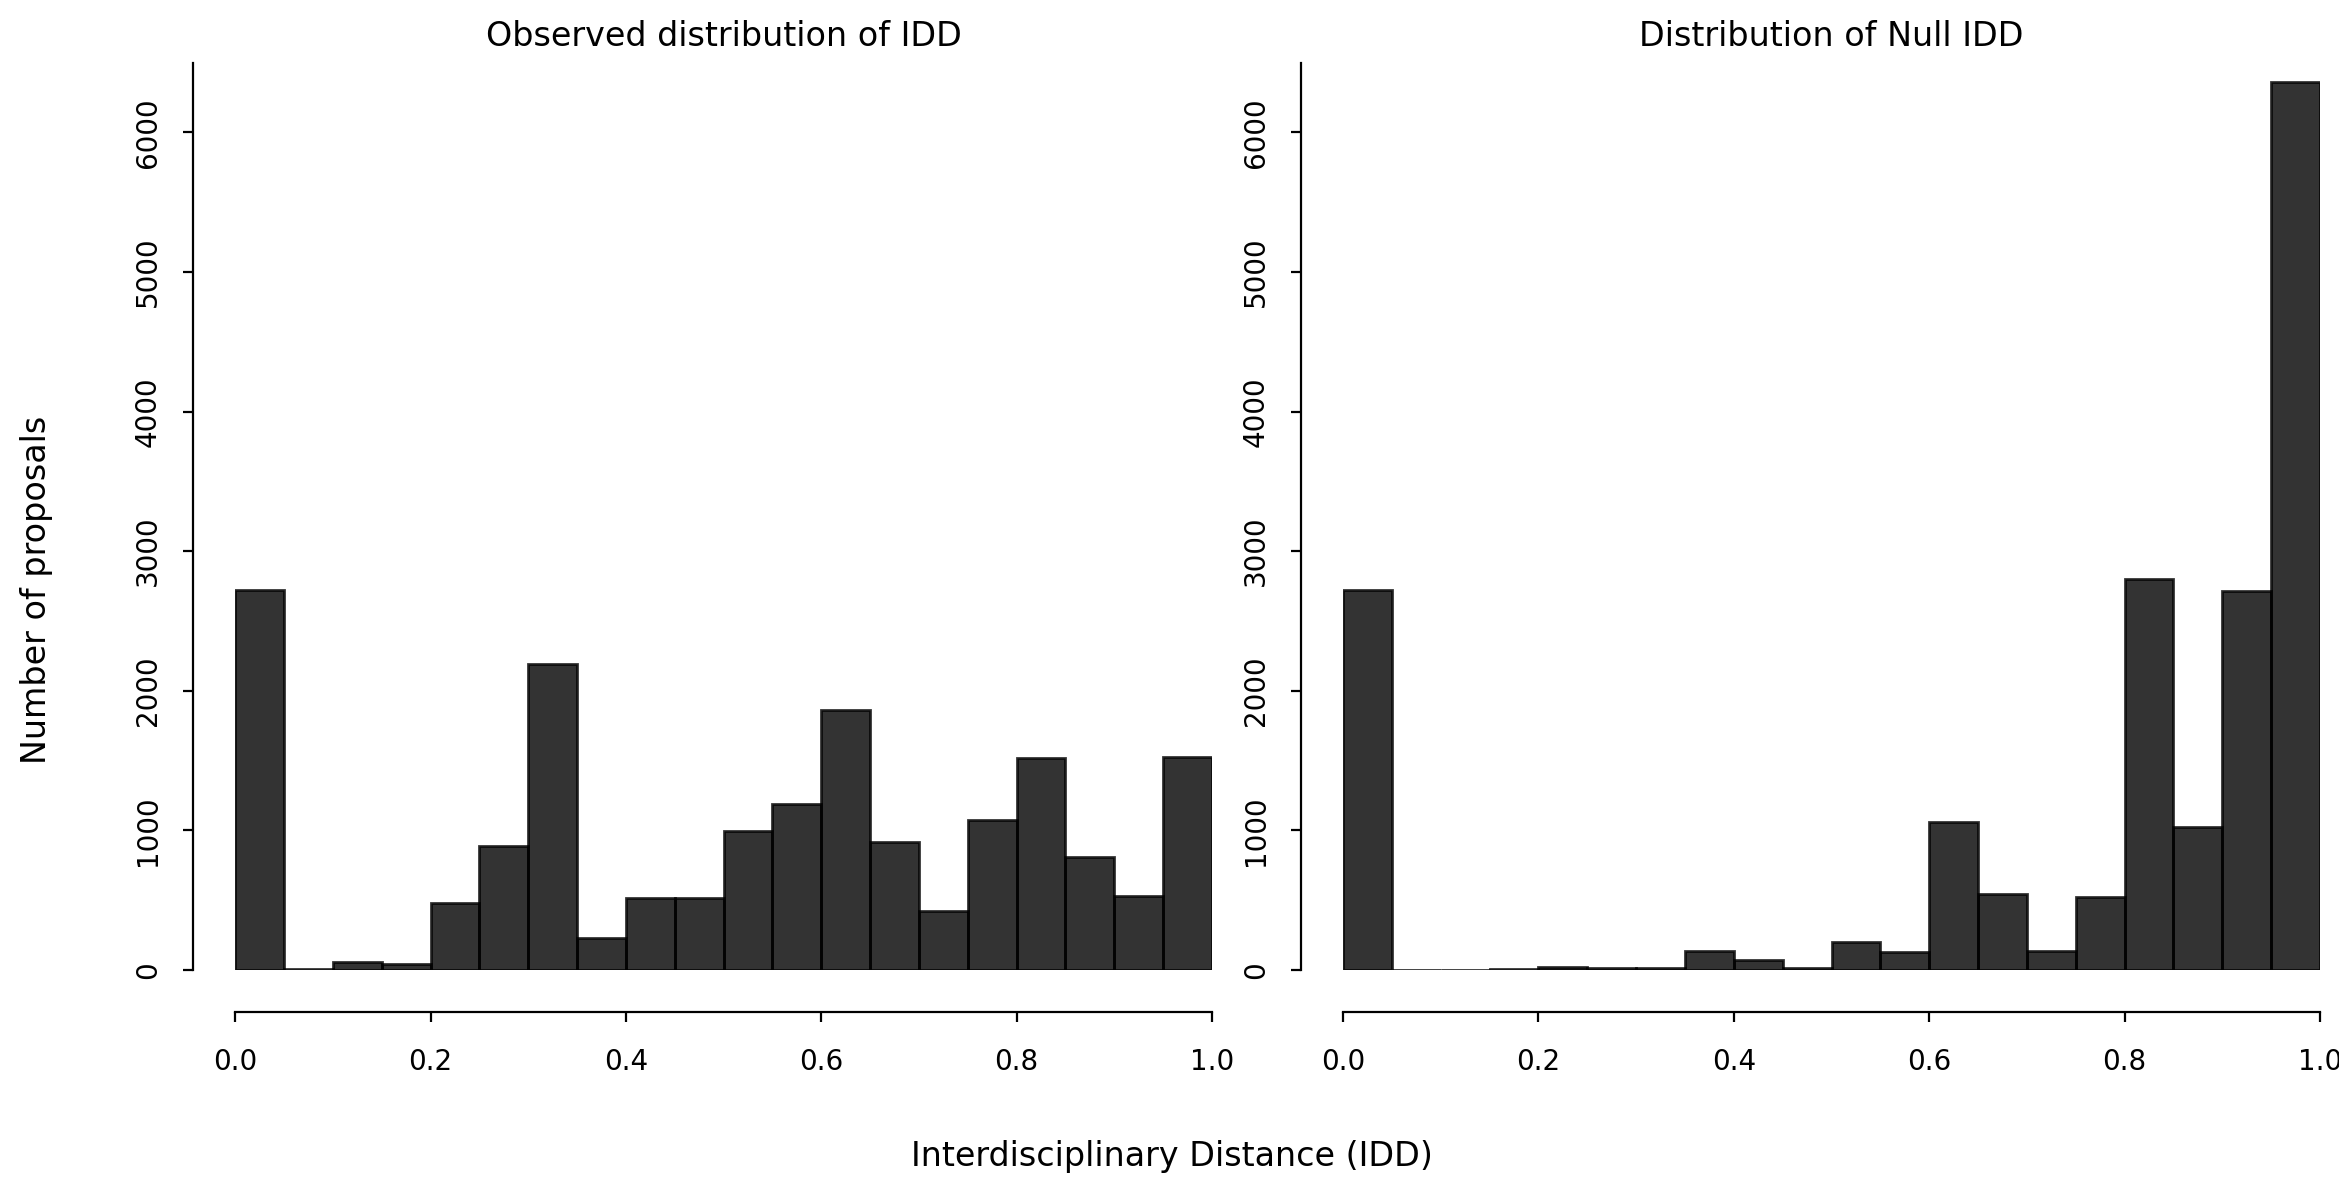

In [12]:
from mpl_toolkits import axisartist
from mpl_toolkits.axes_grid1 import host_subplot

# Create figure with two subplots
fig = plt.figure(figsize=(12, 6))
# Add labels for the whole figure
fig.text(0.5, 0.02, 'Interdisciplinary Distance (IDD)', ha='center', fontsize=12)
fig.text(0.02, 0.5, 'Number of proposals', va='center', rotation='vertical', fontsize=12)

axis_offset = 15

# First subplot - Observed distribution
host1 = host_subplot(121, axes_class=axisartist.Axes)
host1.axis["top"].set_visible(False)
host1.axis["right"].set_visible(False)
host1.axis["bottom"].set_visible(False)
host1.axis["left"].set_visible(False)

par1 = host1.twinx()
par1.axis["top"].set_visible(False)
par1.axis["right"].set_visible(False)

par1.axis["bottom"] = par1.new_fixed_axis(loc="bottom", offset=(0, -axis_offset))
par1.axis["left"] = par1.new_fixed_axis(loc="left", offset=(-axis_offset, 0))

par1.axis["bottom"].toggle(all=True)
par1.axis["left"].toggle(all=True)

# Set tick direction for par1
par1.axis["bottom"].major_ticklabels.set_pad(10)
par1.axis["left"].major_ticklabels.set_pad(10)
par1.axis["bottom"].major_ticks.set_tick_out(True)
par1.axis["left"].major_ticks.set_tick_out(True)
par1.axis["left"].major_ticklabels.set_axis_direction("top")

# Plot observed distribution
p1 = par1.hist(observed_scores, bins=20, edgecolor='black', color='black', alpha=0.8)
host1.set_title('Observed distribution of IDD')
par1.set_xlim(0, 1)
par1.set_ylim(0, 6500)

# Important to put the line in the left plot's code block
fig.subplots_adjust(left=0.18, bottom=0.18)

# Second subplot - Null distribution
host2 = host_subplot(122, axes_class=axisartist.Axes)
host2.axis["top"].set_visible(False)
host2.axis["right"].set_visible(False)
host2.axis["bottom"].set_visible(False)
host2.axis["left"].set_visible(False)

par2 = host2.twinx()
par2.axis["top"].set_visible(False)
par2.axis["right"].set_visible(False)

par2.axis["bottom"] = par2.new_fixed_axis(loc="bottom", offset=(0, -axis_offset))
par2.axis["left"] = par2.new_fixed_axis(loc="left", offset=(-axis_offset, 0))

par2.axis["bottom"].toggle(all=True)
par2.axis["left"].toggle(all=True)

# Set tick direction for par2
par2.axis["bottom"].major_ticklabels.set_pad(10)
par2.axis["left"].major_ticklabels.set_pad(10)
par2.axis["bottom"].major_ticks.set_tick_out(True)
par2.axis["left"].major_ticks.set_tick_out(True)
par2.axis["left"].major_ticklabels.set_axis_direction("top")

# Plot null distribution
p2 = par2.hist(null_scores, bins=20, edgecolor='black', color='black', alpha=0.8)
host2.set_title('Distribution of Null IDD')
par2.set_xlim(0, 1)
par2.set_ylim(0, 6500)

plt.tight_layout()
plt.savefig('./assets/reproduced/distribution.png', dpi=300)
plt.show()

/tmp/ipykernel_1323272/3021610955.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_success_rates = df_plot.groupby('IDD_Bin')['Funding_Success'].mean().reset_index()


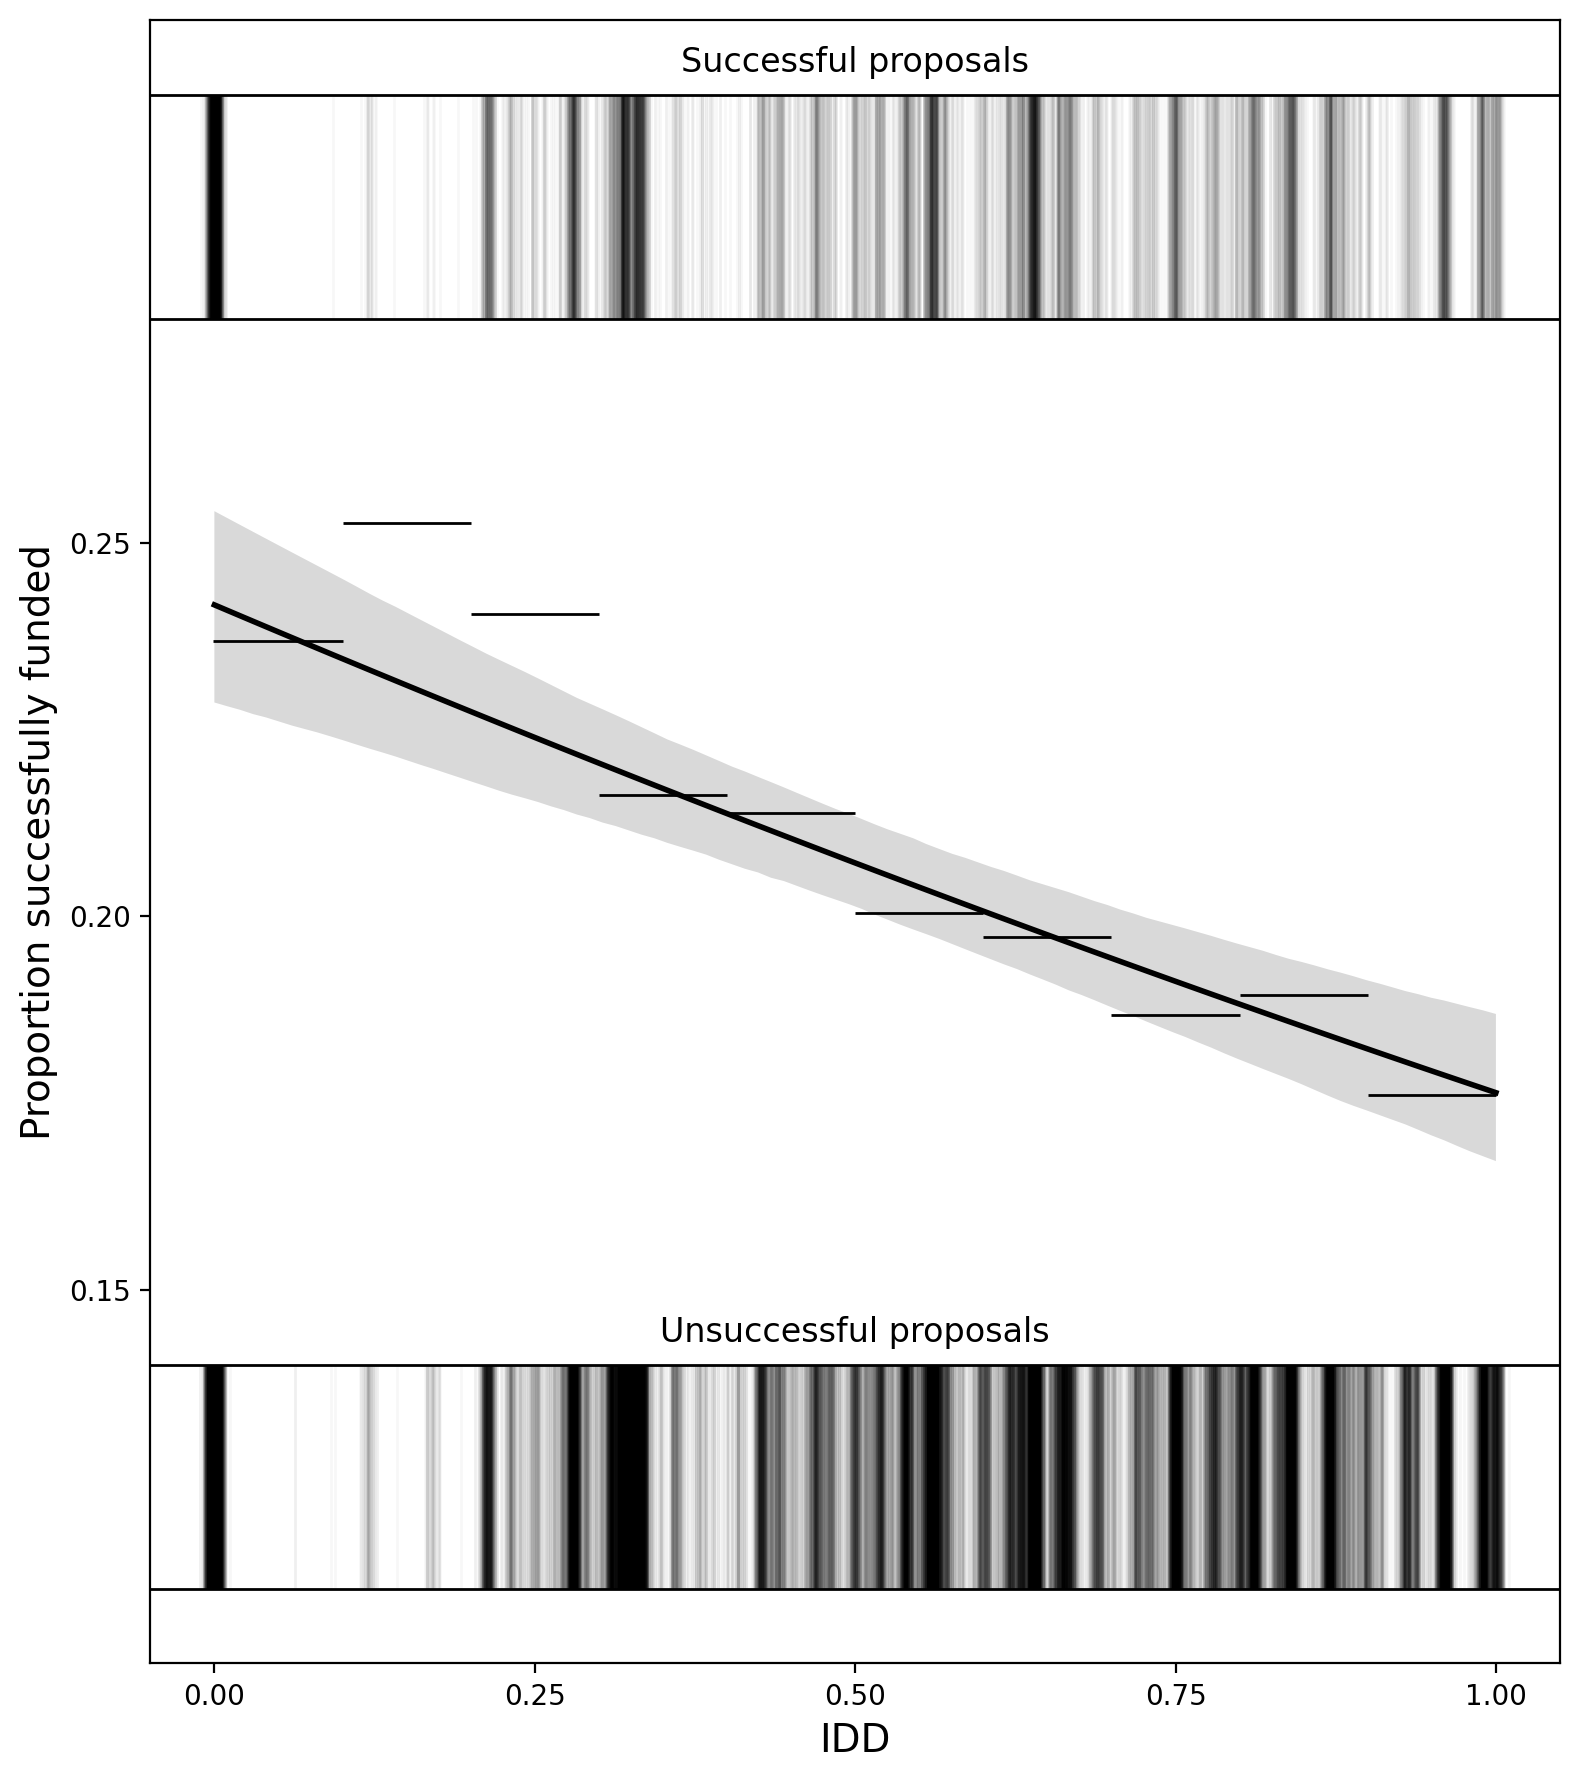

In [ ]:
df['Funding_Success'] = df['Funding status'].apply(lambda x: 1 if x == 'recommendedForFunding' else 0)
df_plot = df[['IDD', 'Funding_Success']].dropna()

# Separate data for rug plots
successful_proposals_idd = df_plot[df_plot['Funding_Success'] == 1]['IDD']
unsuccessful_proposals_idd = df_plot[df_plot['Funding_Success'] == 0]['IDD']

fig, ax = plt.subplots(figsize=(8, 9))

# Plot the regression line
sns.regplot(
    x='IDD',
    y='Funding_Success',
    data=df_plot,
    logistic=True,
    scatter=False,
    line_kws={'color': 'black', 'linewidth': 2},
    ci=95,
    color='grey',
    ax=ax
)

# Plot Bin Means as Horizontal Lines
num_bins = 10
bins = np.linspace(0, 1, num_bins + 1)
df_plot['IDD_Bin'] = pd.cut(df_plot['IDD'], bins=bins, include_lowest=True)
binned_success_rates = df_plot.groupby('IDD_Bin')['Funding_Success'].mean().reset_index()
binned_success_rates['IDD_Midpoint'] = binned_success_rates['IDD_Bin'].apply(lambda x: x.mid)

for _, row in binned_success_rates.iterrows():
    if not pd.isna(row['IDD_Bin'].mid):
        bin_start = row['IDD_Bin'].left
        bin_end = row['IDD_Bin'].right
        ax.hlines(
            y=row['Funding_Success'],
            xmin=bin_start,
            xmax=bin_end,
            color='black',
            linestyle='-',
            linewidth=1
        )

# Plot rug plots using vlines with jitter
y0_top = 0.31
y0_bottom = 0.28
y1_top = 0.14
y1_bottom = 0.11

# Add jitter to successful proposals
jitter_amount = 0.003  # Adjust this to control jitter amount
successful_jittered = successful_proposals_idd + np.random.normal(0, jitter_amount, len(successful_proposals_idd))
ax.vlines(successful_jittered, y0_bottom, y0_top, 
         color='black', linewidth=1, alpha=0.03)

# Add jitter to unsuccessful proposals
unsuccessful_jittered = unsuccessful_proposals_idd + np.random.normal(0, jitter_amount, len(unsuccessful_proposals_idd))
ax.vlines(unsuccessful_jittered, y1_bottom, y1_top, 
         color='black', linewidth=1, alpha=0.03)

# Add titles for rug plots
ax.text(0.5, y0_top + 0.003, 'Successful proposals', ha='center', fontsize=12)
ax.text(0.5, y1_top + 0.003, 'Unsuccessful proposals', ha='center', fontsize=12)

# horizontal lines
ax.hlines(y0_bottom, -0.05, 1.05, color='black', linewidth=1)
ax.hlines(y0_top, -0.05, 1.05, color='black', linewidth=1)
ax.hlines(y1_bottom, -0.05, 1.05, color='black', linewidth=1)
ax.hlines(y1_top, -0.05, 1.05, color='black', linewidth=1)

# Set main axis properties
ax.set_xlabel('IDD', fontsize=14)
ax.set_ylabel('Proportion successfully funded', fontsize=14)
ax.set_ylim(0.1, 0.32)
ax.set_yticks([0.15, 0.20, 0.25])
ax.set_yticklabels(['0.15', '0.20', '0.25'])
ax.set_xlim(-0.05, 1.05)
ax.set_xticks(np.arange(0, 1.01, 0.25))
ax.set_xticklabels(['0.00', '0.25', '0.50', '0.75', '1.00'])
ax.grid(False)

plt.tight_layout()
plt.savefig('./assets/reproduced/fig1.png', dpi=300)
plt.show()

In [15]:
disciplines_full_map = {
    '01': 'Mathematical Sciences',
    '02': 'Physical Sciences',
    '03': 'Chemical Sciences',
    '04': 'Earth Sciences',
    '05': 'Environmental Sciences', 
    '06': 'Biological Sciences', 
    '07': 'Agricultural and Veterinary Sciences',
    '08': 'Information and Computing Sciences', 
    '09': 'Engineering',                
    '10': 'Mathematical Sciences',      
    '11': 'Medical and Health Sciences', 
    '12': 'Built Environment and Design', 
    '13': 'Education',                  
    '14': 'Economics',                  
    '15': 'Commerce, Management, Tourism & Services', 
    '16': 'Studies in Human Society',   
    '17': 'Psychology and Cognitive Sciences', 
    '18': 'Law and Legal Studies',      
    '19': 'Studies in Creative Arts and Writing', 
    '20': 'Language, Communication and Culture', 
    '21': 'History and Archaeology',    
    '22': 'Philosophy and Religious Studies'  
}


## Use GLM instead of GLMM in the paper for easier implementation

leads to small different results

In [16]:
# Extract the Division (first two digits) from Primary FOR Cd
df['Division'] = df['Primary FOR Cd'].apply(lambda x: str(x).zfill(4)[:2])
df['funding status'] = df['Funding status'].apply(lambda x: 1 if x == 'recommendedForFunding' else 0)
df['funding status'] = df['funding status'].astype(int)

# GLM Fitting and Y-value Calculation

# Define the reference Division (as per the paper, Mathematical Sciences, which is '01' FOR Division)
reference_division = '01'
if reference_division not in df['Division'].unique():
    print(f"Warning: Reference division '{reference_division}' not found in your data. Using the first unique division as reference.")
    reference_division = df['Division'].unique()[0]

# Fit the Generalized Linear Model (GLM)
# Formula: 'funding status' as outcome, predicted by 'IDD', 'Division', and their interaction.
# 'IDD * C(Division, Treatment(reference=...))' automatically creates main effects and interactions.
# 'C(...)' ensures Division is treated as a categorical variable.
model = smf.glm(
    formula=f'Q("funding status") ~ IDD * C(Division, Treatment(reference="{reference_division}"))',
    data=df,
    family=sm.families.Binomial() # Use Binomial family for binary outcomes
).fit()

plot_data = []

beta_idd_overall = model.params['IDD']

# Iterate through each unique Division to calculate its specific Y-value (IDD effect)
for division_code in df['Division'].unique():
    division_df = df[df['Division'] == division_code].copy()

    # Skip divisions with too few proposals for reliable calculations
    if len(division_df) < 50:
        continue

    # X-axis value: Overall success rate for the discipline
    overall_success_rate = division_df['funding status'].mean()
    std_err_overall_success = np.sqrt(overall_success_rate * (1 - overall_success_rate) / len(division_df))

    num_submissions = len(division_df)

    # Calculate Y-value: β_IDD_overall + β_IDD_x_Division_j
    if division_code == reference_division:
        # For the reference division, the interaction term is zero by definition
        beta_idd_division = beta_idd_overall
        std_err_idd_division = model.bse['IDD'] # Standard error of the main IDD effect
    else:
        # Get the interaction term's coefficient for this specific division
        interaction_term_name = f'IDD:C(Division, Treatment(reference="{reference_division}"))[T.{division_code}]'
        if interaction_term_name in model.params:
            interaction_beta = model.params[interaction_term_name]
            beta_idd_division = beta_idd_overall + interaction_beta

            # Calculate the standard error for the sum of correlated variables (main effect + interaction)
            cov_matrix = model.cov_params() # Get the covariance matrix of parameters
            idx_idd = model.params.index.get_loc('IDD')
            idx_interaction = model.params.index.get_loc(interaction_term_name)
            
            var_idd = cov_matrix.iloc[idx_idd, idx_idd]
            var_interaction = cov_matrix.iloc[idx_interaction, idx_interaction]
            cov_idd_interaction = cov_matrix.iloc[idx_idd, idx_interaction] # Covariance term
            
            std_err_idd_division = np.sqrt(var_idd + var_interaction + 2 * cov_idd_interaction)
        else:
            # If the interaction term doesn't exist (e.g., for divisions with very few proposals), skip
            print(f"Warning: Interaction term for Division {division_code} not found. Skipping this division.")
            continue

    plot_data.append({
        'Division': division_code,
        'Overall_Success_Rate': overall_success_rate,
        'Beta_IDD_Division': beta_idd_division,
        'Std_Err_Beta_IDD_Division': std_err_idd_division,
        'Std_Err_Overall_Success': std_err_overall_success,
        'Num_Submissions': num_submissions
    })

plot_df = pd.DataFrame(plot_data)



### Styling
Push text labels to empty space in the plot
- assign position tag to each data point
- create and filter target positions so that the texts don't overlap

In [17]:
left_th = plot_df['Overall_Success_Rate'].quantile(0.25)
right_th = plot_df['Overall_Success_Rate'].quantile(0.7)

plot_df['tag'] = ''

plot_df.loc[plot_df['Overall_Success_Rate'] < left_th, 'tag'] = 'left'
plot_df.loc[plot_df['Overall_Success_Rate'] > right_th, 'tag'] = 'right'

untagged_mask = plot_df['tag'] == ''
median_beta = plot_df.loc[untagged_mask, 'Beta_IDD_Division'].median()
plot_df.loc[untagged_mask, 'tag'] = np.where(
    plot_df.loc[untagged_mask, 'Beta_IDD_Division'] > median_beta, 
    'top', 
    'bottom'
)

plot_df['tag'].value_counts()

tag
right     7
left      6
bottom    5
top       4
Name: count, dtype: int64

Make some offsets for the text labels not to overlap.

In [18]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

def create_repulsion_offset(values, strength=0.1, radius=0.2):
    n_points = len(values)
    if n_points <= 1:
        return np.zeros(n_points)
    
    # Calculate pairwise distances
    distances = squareform(pdist(values.reshape(-1, 1)))
    
    # Create repulsion forces (inverse of gaussian)
    forces = np.exp(-(distances**2) / (2 * radius**2))
    np.fill_diagonal(forces, 0)  # no self-repulsion
    
    # Calculate offset for each point based on repulsion from others
    offsets = np.zeros(n_points)
    for i in range(n_points):
        # Points that are closer create stronger repulsion
        nearby = forces[i]
        # Direction of force (-1 for points below, +1 for points above)
        direction = np.sign(values - values[i])
        offsets[i] = -np.sum(direction * nearby) * strength
    
    # Normalize offsets to desired range
    if offsets.std() > 0:
        offsets = offsets / offsets.std() * strength
    
    return offsets

# Apply the repulsion offsets
plot_df['y_offset'] = 0.0
plot_df['x_offset'] = 0.0

for tag in plot_df['tag'].unique():
    mask = plot_df['tag'] == tag
    values = plot_df.loc[mask].copy()
    
    if len(values) > 1:
        if tag in ['left', 'right']:
            plot_df.loc[mask, 'y_offset'] = create_repulsion_offset(
                values['Beta_IDD_Division'].values,
                strength=0.04,  # adjust this to control spread
                radius=0.3     # adjust this to control how far points need to be to repel
            )
        else: 
            plot_df.loc[mask, 'x_offset'] = create_repulsion_offset(
                values['Overall_Success_Rate'].values,
                strength=0.01,
                radius=0.2
            )

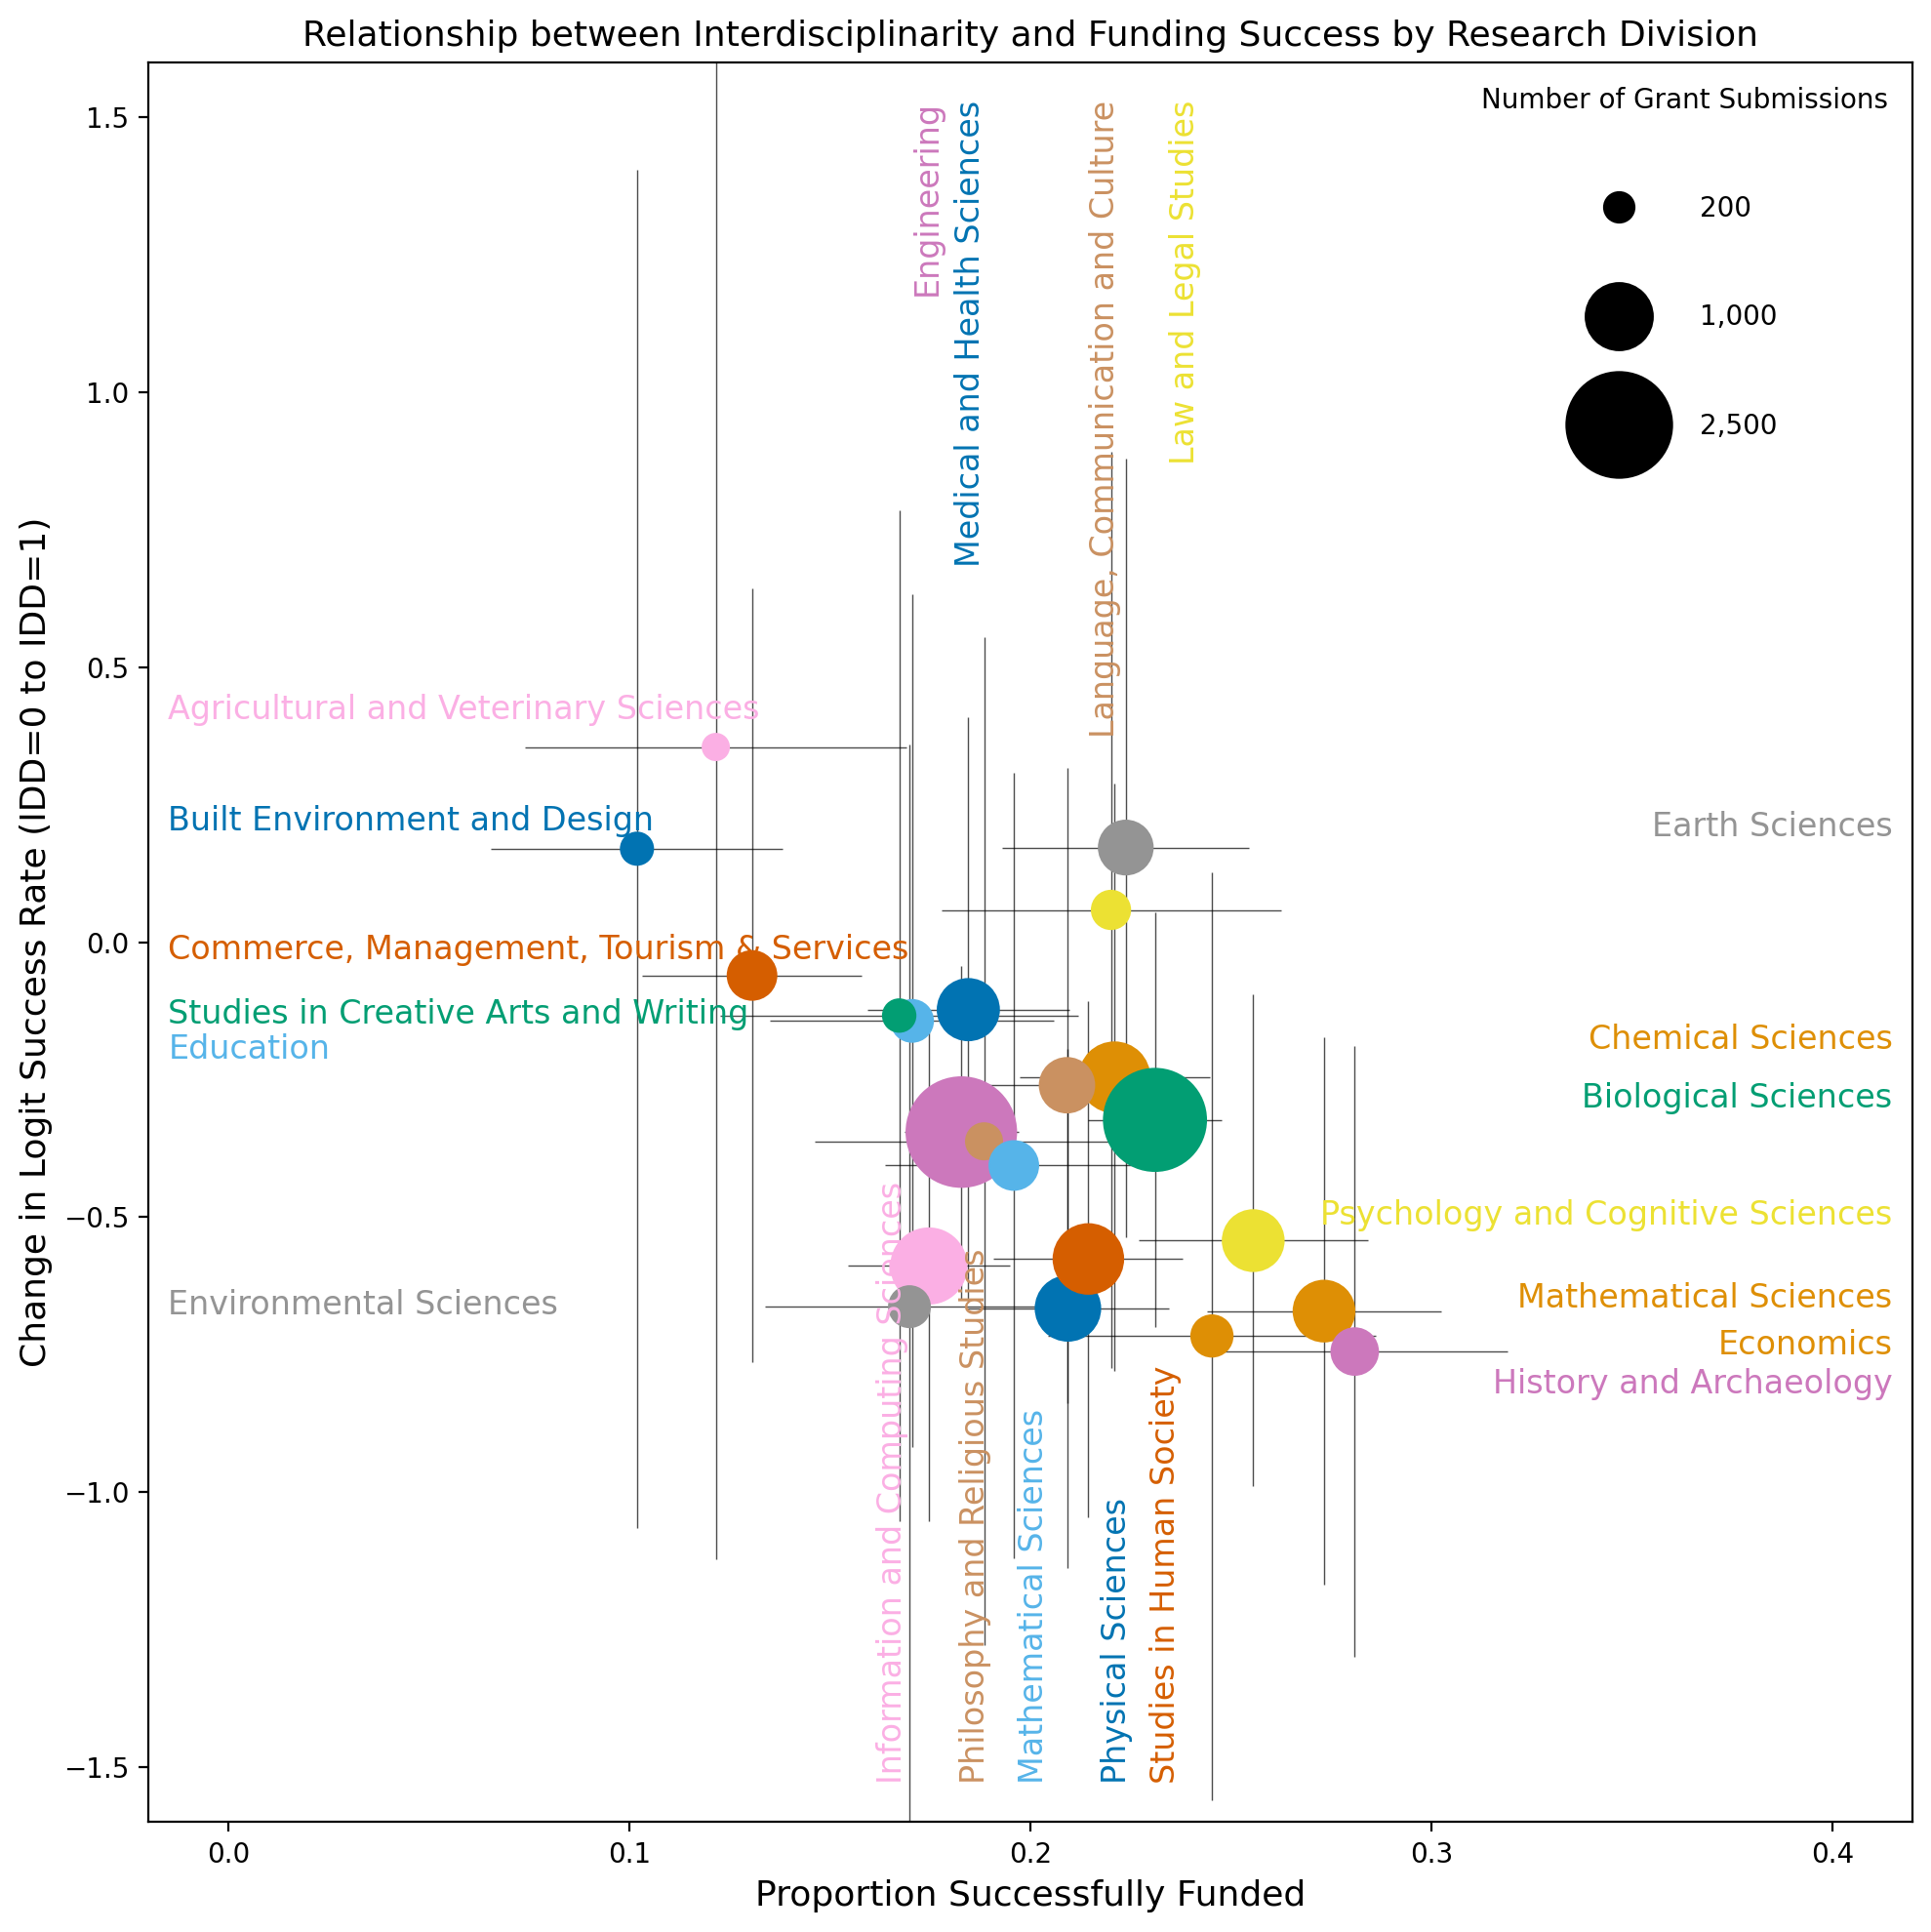

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

unique_divisions = plot_df['Division'].unique()
n_divisions = len(unique_divisions)

# colors_rgb = sns.husl_palette(n_divisions, l=.7, s=.8)
# colors_rgb = sns.color_palette("husl", n_colors=22)
colors_rgb = sns.color_palette("colorblind", n_colors=22)


division_colors = dict(zip(unique_divisions, colors_rgb)) 
plot_df['Color'] = plot_df['Division'].map(division_colors)


fig, ax = plt.subplots(figsize=(10, 10))
error_x = ax.errorbar(
    x=plot_df['Overall_Success_Rate'], y=plot_df['Beta_IDD_Division'],
    xerr=plot_df['Std_Err_Overall_Success'] * 1.96, # 95% CI
    fmt='none', 
    ecolor='black',
    capsize=0,
    alpha=0.7,
    zorder=1, 
    elinewidth=0.5
)
error_y = ax.errorbar(
    x=plot_df['Overall_Success_Rate'], y=plot_df['Beta_IDD_Division'],
    yerr=plot_df['Std_Err_Beta_IDD_Division'] * 1.96, # 95% CI
    fmt='none',
    ecolor='black',
    capsize=0,
    alpha=0.7,
    zorder=1,  
    elinewidth=0.5 
)

size_multiplier = 0.6 # Adjust this value to scale circle sizes appropriately
scatter = ax.scatter(
    x=plot_df['Overall_Success_Rate'],
    y=plot_df['Beta_IDD_Division'],
    s=plot_df['Num_Submissions'] * size_multiplier,
    c=plot_df['Color'],
    alpha=1,
    edgecolors='black', 
    linewidths=0, 
    zorder=2 
)

# Add Text Labels for each Division
division_names_map = disciplines_full_map
plot_df['Division_Name'] = plot_df['Division'].map(division_names_map).fillna(plot_df['Division'])

for i, row in plot_df.iterrows():
    # Default pos
    x = row['Overall_Success_Rate'] + 0.005
    y = row['Beta_IDD_Division'] + 0.02
    ha = 'center'
    va = 'center'
    rotation = None

    match row['tag']:
        case 'left':
            x = -0.015 + row['x_offset']
            y = y + row['y_offset'] 
            ha = 'left'
        case 'right':
            x = 0.415 + row['x_offset']
            y = y + row['y_offset'] 
            ha = 'right'
        case 'top':
            x = x + row['x_offset'] 
            y = 1.53
            va = 'top'
            rotation = 'vertical'
        case 'bottom':
            x = x + row['x_offset'] 
            y = -1.53
            va = 'bottom'
            rotation = 'vertical'
    ax.text(
        x,
        y,
        row['Division_Name'],
        ha=ha,
        va=va,
        rotation=rotation,
        horizontalalignment='left',
        fontsize=12,
        color=row['Color'],
        alpha=1,
        zorder=3 
    )

ax.set_title('Relationship between Interdisciplinarity and Funding Success by Research Division', fontsize=13)
ax.set_xlabel('Proportion Successfully Funded', fontsize=13)
ax.set_ylabel('Change in Logit Success Rate (IDD=0 to IDD=1)', fontsize=13)

ax.set_xlim(-0.02, 0.42)
ax.set_xticks(np.arange(0.0, 0.41, 0.1))
ax.set_ylim(-1.6, 1.6)
ax.set_yticks(np.arange(-1.5, 1.51, 0.5))

legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='200', markersize=np.sqrt(200 * size_multiplier), markerfacecolor='black', markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', label='1,000', markersize=np.sqrt(1000 * size_multiplier), markerfacecolor='black', markeredgecolor='black'),
    plt.Line2D([0], [0], marker='o', color='w', label='2,500', markersize=np.sqrt(2500 * size_multiplier), markerfacecolor='black', markeredgecolor='black')
]
ax.legend(handles=legend_elements, handletextpad=2, title='Number of Grant Submissions', loc='upper right', bbox_to_anchor=(1.0, 1.0), frameon=False, labelspacing=3)

ax.grid(False)
plt.tight_layout()
plt.savefig('./assets/reproduced/fig2.png', dpi=300)
plt.show()
